# P2 B - Regresión Logística
Hecho por:
- Jaime Benedi
- Miguel Sevilla

El hecho de si hay riesgo cardiovascular depende de diversos factores como por ejemplo la presión arterial y el colesterol.
1. Genera un dataset sintético que va a contener 800 instancias que representen personas. Cada persona va a tener los siguientes atributos:
    - Valores de presión arterial y colesterol. Ten en cuenta que el nivel normal de colesterol se considera por debajo de 180, aunque puede variar entre 120 y 250, y el nivel normal de presión arterial sistólica se encuentra entre 100 y 120, aunque puede variar entre 70 y 180.
    - Valores aleatorios de otro atributo que simule otros datos de la persona (pueden ser inventado).
2. Para cada instancia, calcula la probabilidad de tener problemas vasculares. Ten en cuenta las consideraciones sobre los valores de presión arterial y colesterol.
3. En base a un umbral, para cada instancia (teniendo en cuenta la probabilidad calculada en el punto 2), determina la clase de tener riesgo cardiovascular (1) o no (0).
4. Dibuja la gráfica de los datos con respecto a la presión arterial (eje X por ejemplo) y el colesterol (eje Y por ejemplo). Muestra las predicciones utilizando diferentes dibujos para cada punto. Al mostrar los datos generados, observa si guardan cierta coherencia, para que sea posible al regresor aprender. Si lo necesitas, cambia los datos generados.
5. Entrena un regresor logístico (e.g. con clase LogisticRegression) con esos datos.
6. Vuelve a dibujar la gráfica de los datos, dibujando también la curva de la regresión que separa las clases.
7. Genera regresión logística para otro conjunto de personas (500) instancias y dibuja la misma gráfica que en el punto 6. Compara el resultado de la gráfica obtenida con el nuevo conjunto de personas y con el conjunto de personas anterior.

## Librerías a usar

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

SEED = 42
np.random.seed(SEED)

## Generación de datos

Definiremos la generación de datos para las variables de presión arterial, colesterol e índice de grasa corporal (elegida por nosotros). Esta variable irá en escala del 1 al 100 (por conveniencia, representamos en unidades el porcentaje), aunque esperamos acotarlo entre 10 y 60.

Para que los datos sigan distribuciones normales, consideramos, para seguir el enunciado:
- Presión arterial $\rightarrow$ media = 110, desviación típica = 15 $\rightarrow$ niveles normales entre 100 y 120
- Colesterol $\rightarrow$ media = 180, desviación típica = 25 $\rightarrow$ niveles normales entre 120 y 250
- Índice de grasa $\rightarrow$ media = 18, desviación típica = 4

Para la genereación de datos de una manera aproximada y generalizada a esta, implementamos:

In [38]:
def genDataset(
    minPres : float,
    maxPres : float, 
    avgPres : float,
    funcPres,
    minCol : float,
    maxCol : float, 
    avgCol : float,
    funcCol,
    minOther : float,
    maxOther : float, 
    avgOther : float,
    labelOther : str,
    funcOther,
    size: int
) -> pd.DataFrame :
    
    xPres = np.random.normal(avgPres, min(avgPres-minPres, maxPres-avgPres)-5, size,)
    xCol = np.random.normal(avgCol, min(avgCol-minCol, maxCol-avgCol)-5, size)
    xOther = np.random.normal(avgOther, min(avgOther-minOther, maxOther-avgOther)-5, size)
    
    # polinomio de los pesos de las probabilidades
    probRiesgo = np.vectorize(funcPres)(xPres) + funcCol(xCol) + funcOther(xOther)
    # consideremos en riesgo a todas aquellas personas con una probabilidad acumulada mayor a un medio
    riesgo = (probRiesgo > 0.5).astype(int)
            
    return pd.DataFrame({"Presion": xPres, "Colesterol" : xCol, labelOther: xOther, "Riesgo": riesgo})

Bajo los criterios de de probabilidad de:

In [39]:
def arterial_pressure_risk(x) -> float:
        if (x < 100) :
            return (50 + (100-x))/70
        elif (x > 120) :
            return (x - 100) / 50
        else :
            return (x - 100) / 100
        
def colestherol_risk(x) -> float:
        return (x - 180) / 50
    
def fat_index_risk(x) -> float:
        return (x - 20) / 40

Bajo parametros de frontera de intervalo, media y finalmente el tamaño poblacional

In [40]:
(miniP, maxiP, avgP) = (70, 180, 110)
(miniC, maxiC, avgC) = (120, 250, 160)
(miniF, maxiF, avgF) = (10, 65, 22)
population_size = 800

In [41]:
data = genDataset(miniP, maxiP, avgP, arterial_pressure_risk, miniC, maxiC, avgC, colestherol_risk, miniF, maxiF, avgF, "Indice Grasa", fat_index_risk, population_size)
print(data)
print(data["Riesgo"].value_counts())

        Presion  Colesterol  Indice Grasa  Riesgo
0    127.384995  192.839933     20.719725       1
1    105.160749  141.938435     31.624135       0
2    132.669099  163.364227     17.478251       0
3    163.306045  143.820365     16.405656       0
4    101.804632  144.792632     18.620795       0
..          ...         ...           ...     ...
795  146.860350  124.659425     11.852483       0
796  108.615570  181.670399     15.546981       0
797  133.852524  232.012341     14.972298       1
798  110.991143  160.727780     23.450871       0
799  111.041465  134.519897     22.485410       0

[800 rows x 4 columns]
Riesgo
0    403
1    397
Name: count, dtype: int64


Vemos que hay cierto balance en la muestra generada (la mayoría de las veces por la aleatoriedad de las funciones)

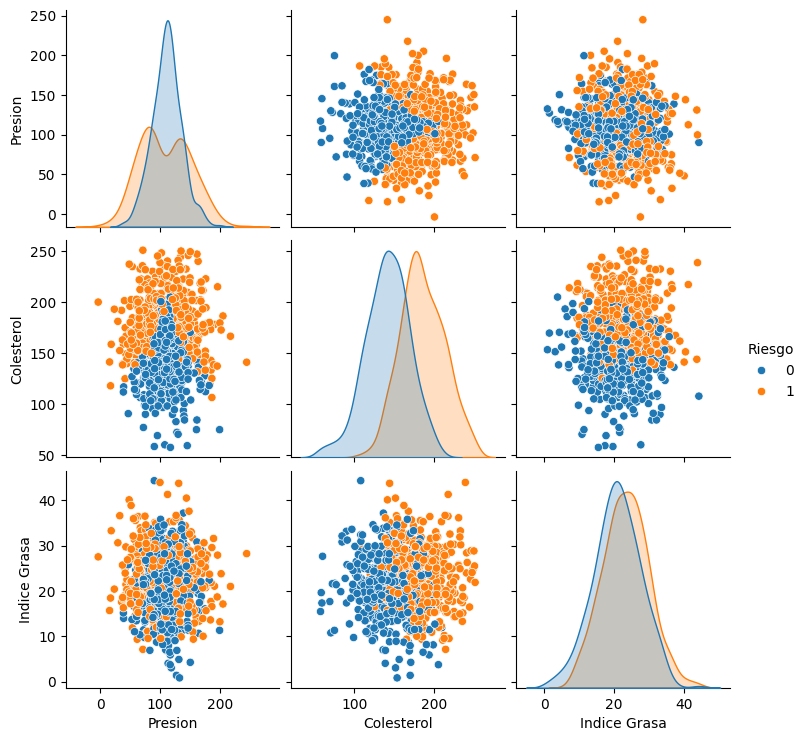

In [42]:
sns.pairplot(data, hue="Riesgo")

Observamos que donde puede haber más incoherencia es con la combinación de Índice de grasa y Presión. Entre Presión-Colesterol, Colesterol-Indice de grasa vemos una clara división

In [43]:
def plot_data(x1, x2, y, label1, label2) :
    sns.scatterplot(x=x1, y=x2, hue=y, palette=['red', 'black'])
    plt.xlabel(label1)
    plt.ylabel(label2)
    plt.title("Datos")
    plt.legend(["Alto Riesgo (1)", "Bajo Riesgo (0)"])

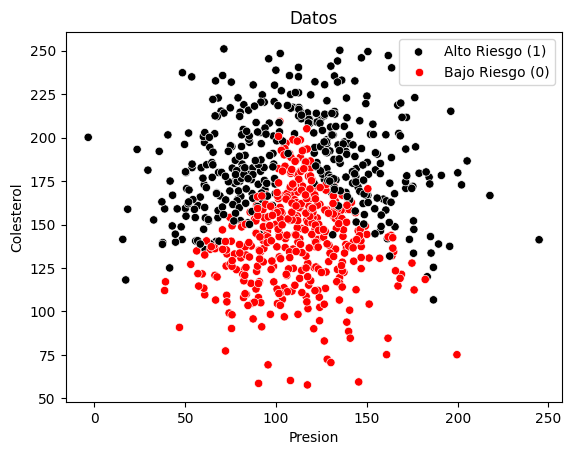

In [44]:
plot_data(data["Presion"], data["Colesterol"], data["Riesgo"], "Presion", "Colesterol")
plt.show()

## Regresión Logística

COnstruimos el modelo de regresión logística con cierta regularización

In [45]:
modelo = LogisticRegression(random_state=SEED, C=0.4) # C == coeficiente de regularización

Extraemos y dividimos los datos

In [46]:
X = data[["Presion", "Colesterol", "Indice Grasa"]]
y = data ["Riesgo"]


# Dividimos la muestra en un 66% para entrenamiento, 33% para test
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.33, random_state=SEED)

Y entrenamos el modelo con las herramientas que nos ofrece la librería

In [47]:
modelo.fit(xTrain, yTrain)

LogisticRegression(C=0.4, random_state=42)

También aprovechamos las herramientas del SciKit para calcular la precisión del modelo:

In [48]:
predicciones = modelo.predict(xTest)
print("Precision del modelo: ", accuracy_score(yTest, predicciones))

Precision del modelo:  0.7916666666666666


Con un coeficiente de regularización por debajo del 0.5, conseguimos buenos resultados de predicción, como podemos observar. Esto puede deberse a que hay una ligera super posición entre las clases y este coeficiente permite evitar no sobre ajustarse a los datos de entrenamiento.

## Muestreo de datos

Generaremos un nuevo modelo adaptado a las dos variables a mostrar. Esto lo hacemos para no tener que complicarnos con representaciones tridimensionales de la muestra, acomodando el muestreo. Pero, esto obliga a reentrenar al modelo para que solo tenga en cuenta dos variables en vez de 3.

In [ ]:
new_modelo = LogisticRegression(random_state=SEED, C=0.4)

X2 = data[["Presion", "Colesterol"]]
y2 = data["Riesgo"]

# Realizamos una partición de unos dos tercios para el entrenamiento del modelo
xTrain, xTest, yTrain, yTest = train_test_split(X2, y2, test_size=0.33, random_state=SEED)

new_modelo.fit(xTrain, yTrain)
print("Precision del modelo: ", accuracy_score(yTest, new_modelo.predict(xTest)))

Precision del modelo:  0.8257575757575758


Observamos que conseguimos cifras similares.

Nuestra implementación de la gráfica es:

In [50]:
def try_draw_contour_and_data(data : pd.DataFrame, modelo, X) -> None :
    
    x_min, x_max = X[:, 0].min() - 5, X[:, 0].max() + 5
    y_min, y_max = X[:, 1].min() - 5, X[:, 1].max() + 5
    
    # Montamos una malla para a lo largo del espacio de puntos para probar e intuir cuales pertenecen a cada clase
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 800), np.linspace(y_min, y_max, 800))
    smth = pd.DataFrame({"Presion":xx.ravel(), "Colesterol":yy.ravel()})
    Z = modelo.predict(smth[["Presion", "Colesterol"]])
    Z = Z.reshape(xx.shape)

    # Graficar los puntos de datos
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=data["Presion"], y=data["Colesterol"], hue=data["Riesgo"], palette=["blue", "red"], alpha=0.7)

    # Dibujar la frontera de decisión
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")

    plt.xlabel("Presión Arterial")
    plt.ylabel("Colesterol")
    plt.title("Frontera de riesgo vascular")
    plt.legend(["Alto Riesgo (1)", "Bajo Riesgo (0)"])
    plt.show()

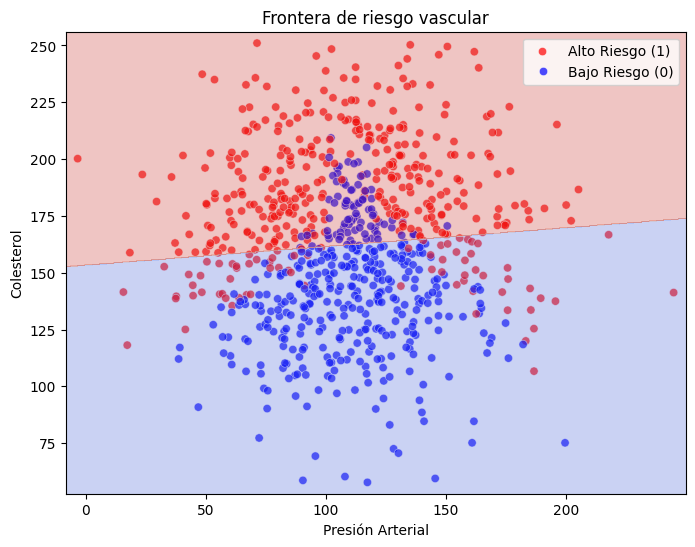

In [51]:
try_draw_contour_and_data(data, new_modelo, X2.values)

Observamos como efectivamente clasifica aproximadamente el 80% de la población de ambas clases en cada región, aunque claramente esta infraajustado.

## Cambio de población

Probamos el codigo redactado con una población menor:

Precision del modelo:  0.7757575757575758


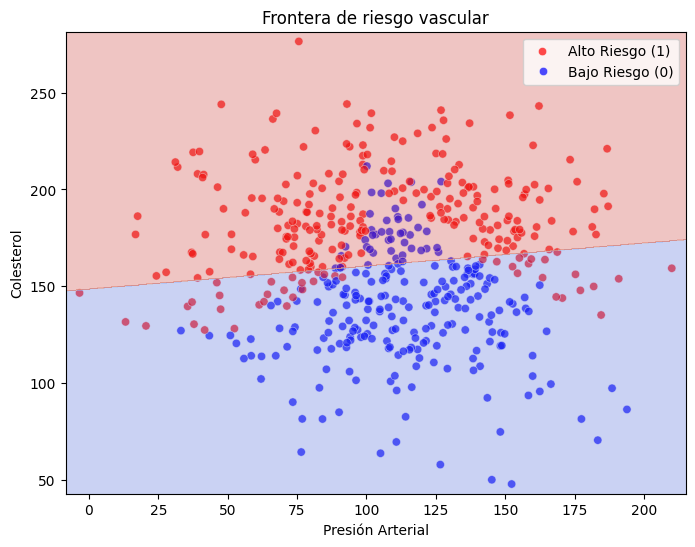

In [ ]:
new_poblacion = 500

new_data = genDataset(miniP, maxiP, avgP, arterial_pressure_risk, miniC, maxiC, avgC, colestherol_risk, miniF, maxiF, avgF, "Indice Grasa", fat_index_risk, new_poblacion)

x = new_data[["Presion", "Colesterol"]]
y = new_data["Riesgo"]

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.33, random_state=SEED)

modelo500 = LogisticRegression(random_state=SEED, C=0.4).fit(xTrain, yTrain)
print("Precision del modelo: ", accuracy_score(yTest, modelo500.predict(xTest)))

try_draw_contour_and_data(new_data, modelo500, x.values)

Observamos una peor predicción de las clases. Esto se debe a que, a menor la población, mayor es el peso de cada elemento en la evaluación de clases, lo que hace que la definición de las fronteras de regresión cambien y las probabilidades de pertenencia a una clase sean más cercanas al 0.5 (indeterminado).